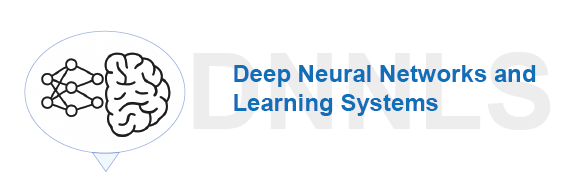

# Week 6: Embedding alchemy - Main Notebook

**Introduction:**
In this notebook we will start working on our assessment task. The first challenge is to create useful representations to be used by the downstream task specified in the brief.

**Learning objectives:**

- Create a data manager for a self-supervision task
- Create a Convolutional neural network that support multiple tasks
- Train and visualize the results
---


# **Lab session**

## Loading the data

In [1]:
from datasets import load_dataset

train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset = load_dataset("daniel3303/StoryReasoning", split="test")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

In [2]:
print(len(train_dataset))
print(train_dataset[0])

3552
{'story_id': '3920', 'images': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAF283C500>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF05C0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF2AB0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF7110>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF7200>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF72F0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF73E0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF74D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF75F0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF7710>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=575x240 at 0x7BFAE3BF78F0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB 

## Creating a data manager

In [3]:
import torch
torch.randint(0, 30, (1,)).item()

24

In [4]:
# Create a dataset
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms

class ImageTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(), # HxWxC -> CxHxW
          #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
      num_frames = self.dataset[idx]["frame_count"]
      frames = self.dataset[idx]["images"]

      # Pick a frame at random
      frame_idx = torch.randint(0, num_frames-1, (1,)).item()
      input_frame = self.transform(frames[frame_idx]) # Input to the neural netwokr

      # Pick the next frame in the sequence
      next_frame_idx = frame_idx + 1
      next_transform = transforms.ToTensor()
      next_frame = next_transform(frames[next_frame_idx])

      # Compute the average color of the next frame
      average_color = torch.mean(next_frame, dim = (1, 2)) # Mean color

      return input_frame, average_color # x, y


my_dataset = ImageTaskDataset(train_dataset) # Instantiate the dataset
my_dataloader = DataLoader(my_dataset, batch_size=32, shuffle=True) # Instantiate the dataloader
# print(my_dataset[8])


## Creating a model

In [5]:
import torch.nn as nn # Layer
import torch.nn.functional as F # functions

class VisualEncoder( nn.Module ):
  def __init__(self):
    super().__init__()
    # Define convolutional layers
    self.conv1 = nn.Conv2d(3, 16, kernel_size=11, padding=1) # 16x226x226
    self.pool1 = nn.MaxPool2d(kernel_size=2)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2)
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.pool3 = nn.AdaptiveAvgPool2d((4,4)) # 64x4x4

    self.feature_block = nn.Sequential(self.conv1,
                                       nn.ReLU(),
                                       self.pool1,
                                       self.conv2,
                                       nn.ReLU(),
                                       self.pool2,
                                       self.conv3,
                                       nn.ReLU(),
                                       self.pool3)

    # Embeddings
    self.embedding = nn.Sequential(
        nn.Linear(64*4*4, 32),
        nn.ReLU(),
        nn.Linear(32, 8), # 8 is the embedding dimension
    )
    # Task Head
    self.task_head = nn.Sequential(
        nn.Linear(8, 3) # Three colors as outputs
    )

  # ! check identation
  def forward(self, x): # Flow of information
    x = self.feature_block(x) # Extract features with the convolutional layers
    x = torch.flatten(x, start_dim=1) # Flatten
    x = self.embedding(x) # Embedding
    predicted_color = self.task_head(x) # Predict the color
    return x, predicted_color

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VisualEncoder().to(device)

# num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Number of trainable parameters: {num_parameters}")


## Training our model

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epochs in range(10):
  for i, (input_frame, average_color) in enumerate(my_dataloader):
    input_frame = input_frame.to(device) # Send data to GPU
    average_color = average_color.to(device)

    optimizer.zero_grad() # Reset the gradients
    _, predicted_color = model(input_frame) # Compute the predictions
    loss = criterion(predicted_color, average_color) # Loss
    loss.backward() # Compute the gradients
    optimizer.step() # Gradient descent

    if i % 10 == 0:
      print(f"Epoch: {epochs}, Batch: {i}, Loss: {loss.item()}")


Epoch: 0, Batch: 0, Loss: 0.07978206872940063
Epoch: 0, Batch: 10, Loss: 0.029420379549264908
Epoch: 0, Batch: 20, Loss: 0.015911096706986427
Epoch: 0, Batch: 30, Loss: 0.011871966533362865
Epoch: 0, Batch: 40, Loss: 0.009875018149614334
Epoch: 0, Batch: 50, Loss: 0.008606640622019768
Epoch: 0, Batch: 60, Loss: 0.012829619459807873
Epoch: 0, Batch: 70, Loss: 0.007782812230288982
Epoch: 0, Batch: 80, Loss: 0.013870080932974815
Epoch: 0, Batch: 90, Loss: 0.009241290390491486
Epoch: 0, Batch: 100, Loss: 0.008459754288196564
Epoch: 0, Batch: 110, Loss: 0.0057054078206419945
Epoch: 1, Batch: 0, Loss: 0.015787791460752487
Epoch: 1, Batch: 10, Loss: 0.013573866337537766
Epoch: 1, Batch: 20, Loss: 0.009518437087535858
Epoch: 1, Batch: 30, Loss: 0.012166513130068779
Epoch: 1, Batch: 40, Loss: 0.010302802547812462
Epoch: 1, Batch: 50, Loss: 0.007822711020708084
Epoch: 1, Batch: 60, Loss: 0.010163756087422371
Epoch: 1, Batch: 70, Loss: 0.0066380067728459835
Epoch: 1, Batch: 80, Loss: 0.0111167561

## Visualizing the resulting filters

## Visualizing the embeddings

# **Assessment task**


# **Practice exercises**
